In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



from keras.utils import Sequence, to_categorical
from PIL import Image
import tensorflow as tf
from keras.callbacks import EarlyStopping


In [9]:
class SafeImageGenerator(Sequence):
    def __init__(self, directory, target_size, batch_size, class_mode):
        self.directory = directory
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.image_files = []

        # Load image files from directory
        for class_name in os.listdir(directory):
            class_dir = os.path.join(directory, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Valid image formats
                        self.image_files.append(os.path.join(class_dir, file_name))

        self.indexes = np.arange(len(self.image_files))
        self.class_indices = {name: i for i, name in enumerate(sorted(os.listdir(directory)))}
        self.num_classes = len(self.class_indices)

    def __len__(self):
        return (len(self.image_files) + self.batch_size - 1) // self.batch_size  # Ensure we get the right number of batches

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indexes:
            img_file = self.image_files[i]
            try:
                img = Image.open(img_file).convert('RGB').resize(self.target_size)
                img_array = np.array(img) / 255.0  # Normalize the image
                if img_array.shape == (self.target_size[0], self.target_size[1], 3):  # Check for expected shape
                    batch_images.append(img_array)
                    label = self.class_indices[os.path.split(os.path.dirname(img_file))[-1]]
                    batch_labels.append(label)
                else:
                    print(f"Image {img_file} has unexpected shape: {img_array.shape}")
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

        if len(batch_images) == 0:
            raise ValueError("No valid images loaded in this batch.")

        return np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=self.num_classes)


In [10]:
# Set parameters
target_size = (150, 150)
batch_size = 32

# Create generators
train_generator = SafeImageGenerator(
    directory='/kaggle/input/dataset4/data-set/training',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = SafeImageGenerator(
    directory='/kaggle/input/dataset4/data-set/validation',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)


In [11]:
from keras.layers import Input

# Build the model
model = Sequential([
    Input(shape=(target_size[0], target_size[1], 3)),  # Specify input shape with Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer for number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [14]:
# Check if train_generator returns data
x, y = train_generator[0]  # Fetch first batch
print(f"Train batch shape: {x.shape}, Labels shape: {y.shape}")

# Check if validation_generator returns data
x_val, y_val = validation_generator[0]  # Fetch first batch
print(f"Validation batch shape: {x_val.shape}, Labels shape: {y_val.shape}")

Train batch shape: (32, 150, 150, 3), Labels shape: (32, 4)
Validation batch shape: (32, 150, 150, 3), Labels shape: (32, 4)


In [15]:
# Train the model with exception handling
try:
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[early_stop]
    )
except IndexError as e:
    print(f"IndexError occurred during model training: {e}")
except Exception as e:
    print(f"Error occurred during model training: {e}")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Error loading image /kaggle/input/dataset4/data-set/training/limb/IMG0004148.jpg: image file is truncated (14 bytes not processed)
 3/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.1923 - loss: 3.0784   Error loading image /kaggle/input/dataset4/data-set/training/limb/IMG0004134.jpg: image file is truncated (1 bytes not processed)
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3440 - loss: 2.4191 - val_accuracy: 0.4930 - val_loss: 1.0462
Epoch 2/10
 4/16 ━━━━━━━━━━━━━━━━━━━━ 7s 641ms/step - accuracy: 0.8158 - loss: 0.6317Error loading image /kaggle/input/dataset4/data-set/training/limb/IMG0004134.jpg: image file is truncated (1 bytes not processed)
 5/16 ━━━━━━━━━━━━━━━━━━━━ 8s 741ms/step - accuracy: 0.8201 - loss: 0.6208Error loading image /kaggle/input/dataset4/data-set/training/limb/IMG0004148.jpg: image file is truncated (14 bytes not processed)
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7243 - loss: 0.7590 - val_accuracy: 0.9454 - val_loss: 0.3370
Epoch 3/10
Err

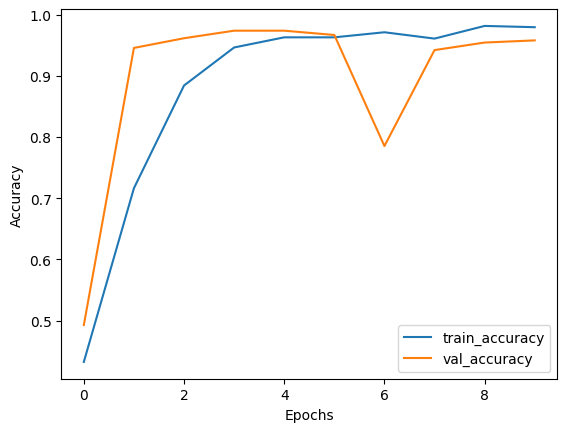

In [16]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 394ms/step - accuracy: 0.9758 - loss: 0.0855
Validation Accuracy: 0.95


In [18]:
model.save('organ_classification_model.h5')


In [37]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = load_model('organ_classification_model.h5')

# Define a list of organ names that correspond to your classes
organs = ['brain', 'breast', 'limb', 'lung']  # Adjust according to your training classes

# Function to predict organ from a single image and calculate accuracy
def predict_organ(img_path, true_class=None):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(150, 150))  # Change to (150, 150)
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    
    predicted_class_index = np.argmax(prediction)
    predicted_class = organs[predicted_class_index]
    predicted_probabilities = prediction[0]  # Get probabilities for each class

    # Display the image
    plt.figure(figsize=(5, 5))  # Set figure size
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted: {predicted_class}\nProbabilities: {predicted_probabilities}")
    plt.show()

    # Calculate accuracy if the true class is provided
    if true_class is not None:
        accuracy = 1.0 if predicted_class == true_class else 0.0
        print(f"True class: {true_class}, Prediction accuracy: {accuracy * 100:.2f}%")
    
    return predicted_class, predicted_probabilities

# Example usage
# Specify the true class for the image you are testing
true_class = 'limb'  # Replace this with the actual class name for your test image
# Test with a sample image
image_path = '/kaggle/input/test111/test/90-rotated1-rotated2-rotated3.jpg'  # Use raw string or forward slashes
predicted_class, predicted_probabilities = predict_organ(image_path, true_class=true_class)
